In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [5]:
# (path/'train'/'3').ls()
(path/'valid').ls()

(#2) [Path('valid/3'),Path('valid/7')]

list of paths to all images of 3 and 7

In [6]:
threes_path = (path/'train/3').ls().sorted()
sevens_path = (path/'train/7').ls().sorted()
threes_path

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

tensors of all images of 3 and 7

In [7]:
three_tensors = [tensor(Image.open(o)) for o in threes_path]
seven_tensors = [tensor(Image.open(o)) for o in sevens_path]
len(three_tensors), len(seven_tensors)

(6131, 6265)

`show_image()` is a function of fastai, that takes a tensor and returns an image 

(<Axes: >, <Axes: >)

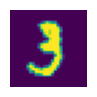

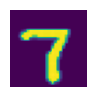

In [8]:
show_image(three_tensors[0]), show_image(seven_tensors[0])

stacked tensor of tensors of images. So a 3D tensor. A list of matrices.

In [9]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
# stacked_threes[1], stacked_sevens[1]

Creating input data for training set by changing 3D to 2D tensor, a list of vectors. Also concatenating 3 and 7 tensors.

In [10]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

creating labels for training set, by labelling a 3 as 1 or True, and 7 as 0 or False.

In [11]:
train_y = tensor([1]*len(threes_path) + [0]*len(sevens_path)).unsqueeze(1)

Creating a `Dataset` object

In [12]:
dset = list(zip(train_x, train_y))

In [13]:
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

now we also create a validation dataset

In [14]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls().sorted()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls().sorted()])
valid_7_tens = valid_7_tens.float()/255

(torch.Size([28, 28]), <Axes: >)

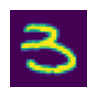

In [58]:
valid_3_tens[0].shape, show_image(valid_3_tens[1])

successful!

In [16]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [54]:
type(valid_dset[0][0])

torch.Tensor

function to initialize random `weights` or `parameters`

In [59]:
torch.manual_seed(0)
def init_params(size, std = 1.0): return (torch.randn(size)*std).requires_grad_()

In [19]:
weights = init_params((28*28, 1))

since the equation is (check notes on why this is the equation) y = w*x + b, we also initialize a random bias

In [20]:
bias = init_params(1)

In [61]:
type(train_x), train_x.shape

(torch.Tensor, torch.Size([12396, 784]))

Create the model

In [21]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 5.8740],
        [-2.5629],
        [ 2.3202],
        ...,
        [17.2968],
        [10.7231],
        [ 9.5250]], grad_fn=<AddBackward0>)

for calculating accuracy we create `corrects` tensor

In [22]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [23]:
corrects.float().mean().item()

0.47483059763908386

for loss function, basic idea is,

In [24]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

applying sigmoid to make sure the result is between 0 and 1

In [25]:
# def sigmoid(x): return 1/(1+torch.exp(-x))

but torch already provides an in-built sigmoid function

In [26]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

creating a dataloader for batching of test dataset

In [28]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

same for validation set

In [29]:
valid_dl = DataLoader(valid_dset, batch_size= 256)

**putting everything together**
the process will be something like this

`for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad*lr`

In [30]:
def calc_grad(xb,yb,model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

one epoch will be,

In [31]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

for calculating accuracy of a batch

In [33]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

putting batches together

In [34]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

first train for one epoch

In [35]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6261

then setup a loop

In [36]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end = ' ')

0.6702 0.8373 0.911 0.9271 0.9369 0.9428 0.9471 0.9496 0.952 0.9535 0.9545 0.9559 0.9564 0.9579 0.9599 0.9613 0.9628 0.9633 0.9633 0.9643 

we can see that the accuracy is certainly getting better

create a function to predict output for an image

In [55]:
# def learn(xb):
    
#     pred = linear1(xb).sigmoid()
#     if pred > 0.5: return 3
#     else: return 7

def accuracy(dl):
    # for xb,yb in dl:
    #     corrects = (linear1(xb).sigmoid()>0.5).float()

    corrects = [(linear1(xb).sigmoid()>0.5).float() for xb,yb in dl]
    return torch.stack(corrects).float().mean()
    

In [56]:
# print(learn(valid_7_tens[435].view(-1, 28*28)))

In [ ]:
accuracy(valid_x)